## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import gmsh
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import scipy
import time
from multiprocessing import Pool
import gc
from gmsh_util import create_normal_mesh,create_box_mesh, read_mesh,plot_distribution,plot_mesh,find_triangle_params
from matplotlib.path import Path

## Validation of quasi-static solver code 
### (using a variable mesh as prescribed in literature)

In [9]:
from worker_rect import picard_helper_rect
from quasi_static_util import quasi_static_fem, quasi_static_picard

In [ ]:
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all = 1,
                                msf_adapt=0.5,
                                side = 6,
                                x_s=50,
                                y_s=25,
                                is_adapt=True
                                )

In [ ]:
# No source
soln_qs = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
h,K,G,F,boundary,theta = soln_qs.fit_ele(mode = "no_source",verbose = False)
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
gc.collect()

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f}C and the minimum temperature is {np.min(theta):.2f} C")

In [ ]:
#Source with physical properties not being a function of temperature
soln_qs = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
_,K,G,F,boundary,theta = soln_qs.fit_ele(mode = "linear",verbose = False)
# h,K,G,F,boundary_term,theta
gc.collect()
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
gc.collect()

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

## Validation of picard iteration

In [26]:
from picard_valid_util import picard_sq, picard_iterative_sq

In [ ]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                msf_all=mesh_size_factor) 
soln3 = picard_sq(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard_iterative_sq(soln3,nodecoords,ele_con,theta_init)

In [ ]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

In [ ]:
gc.collect()

## Newton Raphson validation

In [2]:
from nr_valid_util import nr_sq, nr_iterative_sq

In [ ]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                msf_all=mesh_size_factor) 
soln3 = nr_sq(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = nr_iterative_sq(soln3,nodecoords,ele_con,theta_init)

In [ ]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

## Newton raphson implementation

In [3]:
from transient_util import nr_iterative_rect

### Mesh convergence for static problem

In [29]:
## now find fine mesh size
msf_all = 5
msfs_adapt = np.arange(5,0.4,-0.5)
T_l = 20
rep = np.array([[48,25,0]])
mesh_sizes = []
n_eles = []
T_reps = []

for msf_adapt in msfs_adapt:
    nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                    msf_all=msf_all,
                                    msf_adapt = msf_adapt,
                                    length = 100,
                                    width = 8,
                                    x_s = 50,
                                    y_s = 25) 
    # plot_mesh(nodecoords,ele_con)
    theta_init = np.zeros((nodecoords.shape[0],1))+T_l
    h,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[50,25]]),theta_init,type = "static",mode = "non_linear")
    mesh_sizes.append(h)
    econ,eeta,zeta = find_triangle_params(rep,nodecoords,ele_con)
    N = np.array([[1-eeta-zeta,eeta,zeta]])
    T_reps.append((N@theta_fin[np.ix_(econ,[0])])[0][0])
    n_eles.append(len(ele_con))
    # plot_mesh(nodecoords,ele_con)

Reading reqd_mesh.msh
Number of nodes in the mesh: 308
Number of triangles in the mesh: 552

Error at 1 iteration at time 0 is 1.18E+04
Error at 2 iteration at time 0 is 1.92E+01
Error at 3 iteration at time 0 is 5.57E-05
Number of times phase oscillated : 0
Reading reqd_mesh.msh
Number of nodes in the mesh: 331
Number of triangles in the mesh: 598

Error at 1 iteration at time 0 is 1.16E+04
Error at 2 iteration at time 0 is 1.78E+01
Error at 3 iteration at time 0 is 4.54E-05
Number of times phase oscillated : 0
Reading reqd_mesh.msh
Number of nodes in the mesh: 357
Number of triangles in the mesh: 646

Error at 1 iteration at time 0 is 1.21E+04
Error at 2 iteration at time 0 is 1.88E+01
Error at 3 iteration at time 0 is 4.92E-05
Number of times phase oscillated : 0
Reading reqd_mesh.msh
Number of nodes in the mesh: 380
Number of triangles in the mesh: 692

Error at 1 iteration at time 0 is 1.26E+04
Error at 2 iteration at time 0 is 1.97E+01
Error at 3 iteration at time 0 is 5.23E-05
N

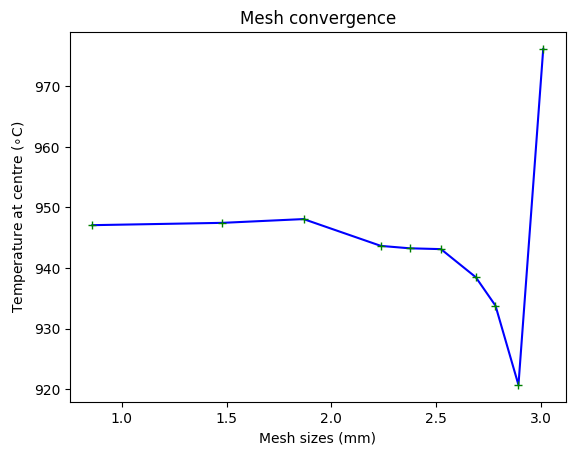

In [32]:
plt.plot(mesh_sizes,T_reps,color='blue', linestyle='-', marker='+', markeredgecolor='green')
plt.title('Mesh convergence')
plt.xlabel('Mesh sizes (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [45]:
T_reps = [ele[0][0] for ele in T_reps]

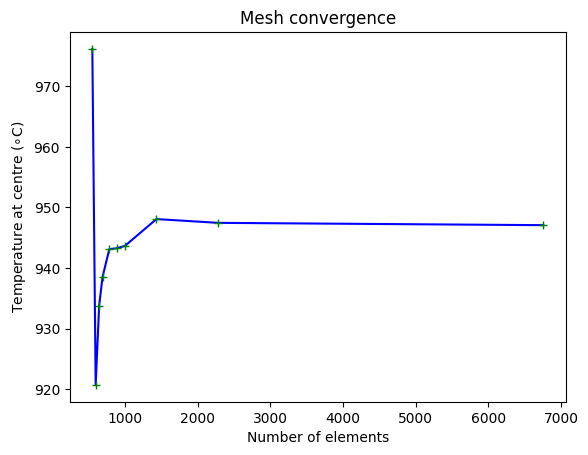

In [33]:
plt.plot(n_eles,T_reps,color='blue', linestyle='-', marker='+', markeredgecolor='green')
plt.title('Mesh convergence')
plt.xlabel('Number of elements')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [8]:
gc.collect()

7211

In [23]:
## now find fine mesh size
converged_msf_adapt = 1.5
msfs = np.arange(10,1.5,-1)
T_l = 20
rep = np.array([[48,40,0]])
mesh_sizes = []
n_eles = []
T_reps = []

for msf in msfs:
    nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                    msf_all=msf,
                                    msf_adapt = converged_msf_adapt,
                                    length = 100,
                                    width = 8,
                                    x_s = 50,
                                    y_s = 25) 
    theta_init = np.zeros((nodecoords.shape[0],1))+T_l
    h,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[50,25]]),theta_init,type = "static",mode = "non_linear")
    mesh_sizes.append(h)
    econ,eeta,zeta = find_triangle_params(rep,nodecoords,ele_con)
    N = np.array([[1-eeta-zeta,eeta,zeta]])
    T_reps.append((N@theta_fin[np.ix_(econ,[0])])[0][0])
    n_eles.append(len(ele_con))

Reading reqd_mesh.msh
Number of nodes in the mesh: 522
Number of triangles in the mesh: 994

Error at 1 iteration at time 0 is 1.51E+04
Error at 2 iteration at time 0 is 2.42E+01
Error at 3 iteration at time 0 is 6.78E-05
Number of times phase oscillated : 0
Reading reqd_mesh.msh
Number of nodes in the mesh: 563
Number of triangles in the mesh: 1072

Error at 1 iteration at time 0 is 1.56E+04
Error at 2 iteration at time 0 is 2.49E+01
Error at 3 iteration at time 0 is 6.96E-05
Number of times phase oscillated : 0
Reading reqd_mesh.msh
Number of nodes in the mesh: 612
Number of triangles in the mesh: 1164

Error at 1 iteration at time 0 is 1.62E+04
Error at 2 iteration at time 0 is 2.60E+01
Error at 3 iteration at time 0 is 7.27E-05
Number of times phase oscillated : 0
Reading reqd_mesh.msh
Number of nodes in the mesh: 649
Number of triangles in the mesh: 1234

Error at 1 iteration at time 0 is 1.67E+04
Error at 2 iteration at time 0 is 2.67E+01
Error at 3 iteration at time 0 is 7.36E-0

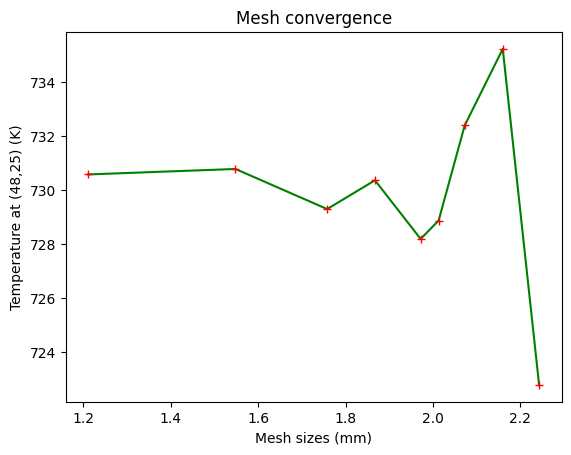

In [27]:
plt.plot(mesh_sizes,T_reps,color='green', linestyle='-', marker='+', markeredgecolor='red')
plt.title('Mesh convergence')
plt.xlabel('Mesh sizes (mm)')
plt.ylabel(r'Temperature at (48,25) (K)')
plt.show()

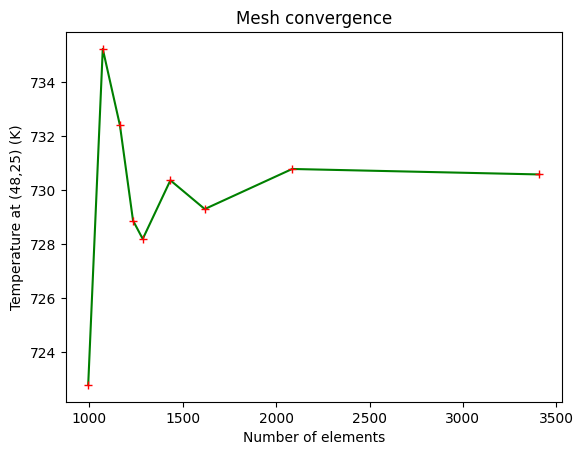

In [28]:
plt.plot(n_eles,T_reps,color='green', linestyle='-', marker='+', markeredgecolor='red')
plt.title('Mesh convergence')
plt.xlabel('Number of elements')
plt.ylabel(r'Temperature at (48,25) (K)')
plt.show()

### Temporal convergence

Reading reqd_mesh.msh
Number of nodes in the mesh: 1100
Number of triangles in the mesh: 2086

Error at 1 iteration at time 0.0 is 1.35E+02
Error at 2 iteration at time 0.0 is 3.30E+00
Error at 3 iteration at time 0.0 is 7.34E-02
Error at 4 iteration at time 0.0 is 1.65E-03
Phase change correction
Error at 1 iteration at time 0.0 is 3.69E-05


Error at 1 iteration at time 0.03333333333333333 is 1.26E+02
Error at 2 iteration at time 0.03333333333333333 is 2.77E+00
Error at 3 iteration at time 0.03333333333333333 is 5.76E-02
Error at 4 iteration at time 0.03333333333333333 is 1.21E-03
Phase change correction
Error at 1 iteration at time 0.03333333333333333 is 2.53E-05


Error at 1 iteration at time 0.06666666666666667 is 1.18E+02
Error at 2 iteration at time 0.06666666666666667 is 2.39E+00
Error at 3 iteration at time 0.06666666666666667 is 4.73E-02
Error at 4 iteration at time 0.06666666666666667 is 9.41E-04
Phase change correction
Error at 1 iteration at time 0.06666666666666667 is 1.8

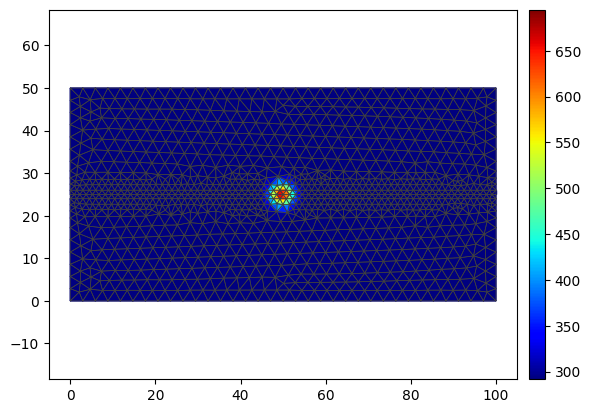

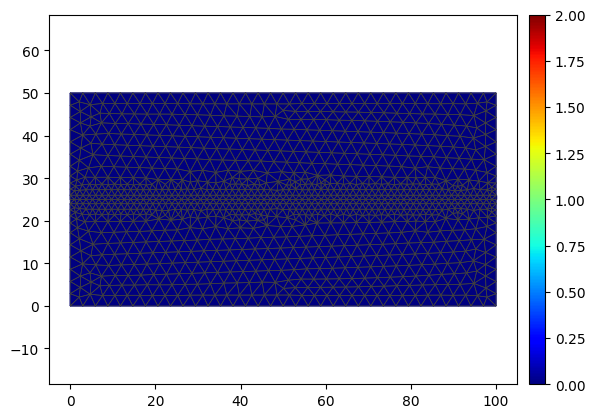

Error at 1 iteration at time 0.3333333333333333 is 8.24E+01
Error at 2 iteration at time 0.3333333333333333 is 1.36E+00
Error at 3 iteration at time 0.3333333333333333 is 2.40E-02
Error at 4 iteration at time 0.3333333333333333 is 4.35E-04
Phase change correction
Error at 1 iteration at time 0.3333333333333333 is 7.95E-06


Error at 1 iteration at time 0.36666666666666664 is 7.99E+01
Error at 2 iteration at time 0.36666666666666664 is 1.31E+00
Error at 3 iteration at time 0.36666666666666664 is 2.33E-02
Error at 4 iteration at time 0.36666666666666664 is 4.25E-04
Phase change correction
Error at 1 iteration at time 0.36666666666666664 is 7.83E-06


Error at 1 iteration at time 0.4 is 7.76E+01
Error at 2 iteration at time 0.4 is 1.28E+00
Error at 3 iteration at time 0.4 is 2.28E-02
Error at 4 iteration at time 0.4 is 4.19E-04
Phase change correction
Error at 1 iteration at time 0.4 is 7.78E-06


Error at 1 iteration at time 0.43333333333333335 is 7.55E+01
Error at 2 iteration at time 0.

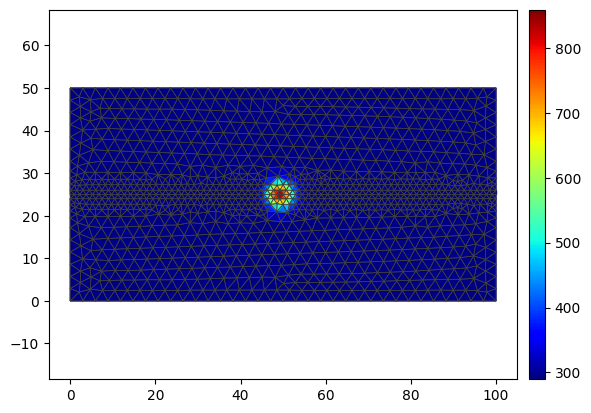

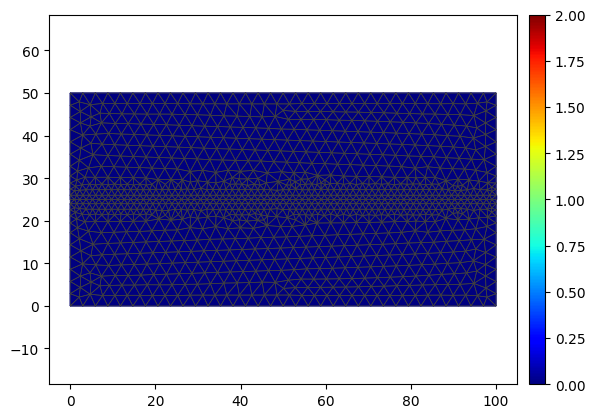

Error at 1 iteration at time 0.6666666666666666 is 6.54E+01
Error at 2 iteration at time 0.6666666666666666 is 1.11E+00
Error at 3 iteration at time 0.6666666666666666 is 2.12E-02
Error at 4 iteration at time 0.6666666666666666 is 4.24E-04
Phase change correction
Error at 1 iteration at time 0.6666666666666666 is 8.63E-06


Error at 1 iteration at time 0.7 is 6.44E+01
Error at 2 iteration at time 0.7 is 1.10E+00
Error at 3 iteration at time 0.7 is 2.12E-02
Error at 4 iteration at time 0.7 is 4.29E-04
Phase change correction
Error at 1 iteration at time 0.7 is 8.85E-06


Error at 1 iteration at time 0.7333333333333333 is 6.35E+01
Error at 2 iteration at time 0.7333333333333333 is 1.09E+00
Error at 3 iteration at time 0.7333333333333333 is 2.12E-02
Error at 4 iteration at time 0.7333333333333333 is 4.35E-04
Phase change correction
Error at 1 iteration at time 0.7333333333333333 is 9.09E-06


Error at 1 iteration at time 0.7666666666666666 is 6.27E+01
Error at 2 iteration at time 0.766666

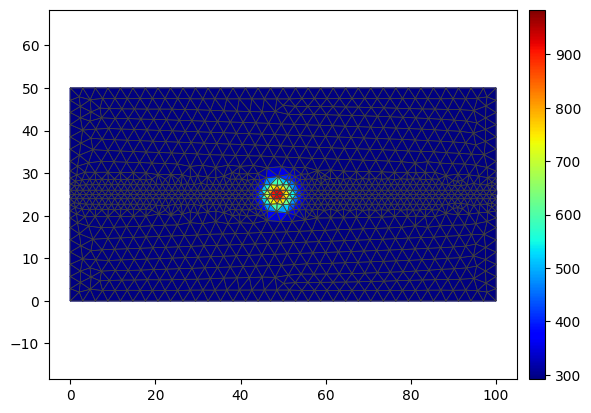

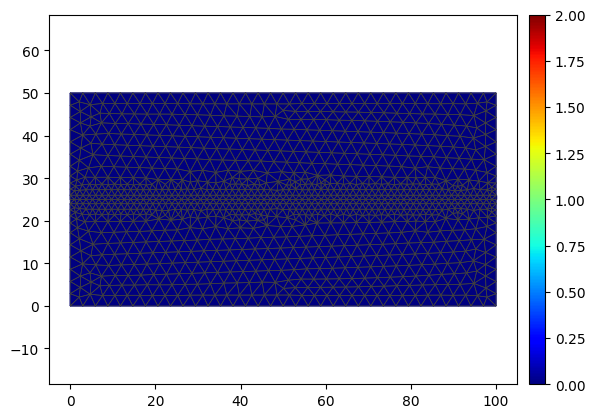

Error at 1 iteration at time 1.0 is 5.85E+01
Error at 2 iteration at time 1.0 is 1.04E+00
Error at 3 iteration at time 1.0 is 2.18E-02
Error at 4 iteration at time 1.0 is 4.88E-04
Phase change correction
Error at 1 iteration at time 1.0 is 1.13E-05


Number of times phase oscillated : 0
Maximum temperature is 991.6938929523263 K
Error at 1 iteration at time 0.0 is 1.60E+02
Error at 2 iteration at time 0.0 is 4.56E+00
Error at 3 iteration at time 0.0 is 1.14E-01
Error at 4 iteration at time 0.0 is 2.86E-03
Phase change correction
Error at 1 iteration at time 0.0 is 7.18E-05


Error at 1 iteration at time 0.04 is 1.48E+02
Error at 2 iteration at time 0.04 is 3.68E+00
Error at 3 iteration at time 0.04 is 8.46E-02
Error at 4 iteration at time 0.04 is 1.96E-03
Phase change correction
Error at 1 iteration at time 0.04 is 4.53E-05


Error at 1 iteration at time 0.08 is 1.37E+02
Error at 2 iteration at time 0.08 is 3.09E+00
Error at 3 iteration at time 0.08 is 6.68E-02
Error at 4 iteration at 

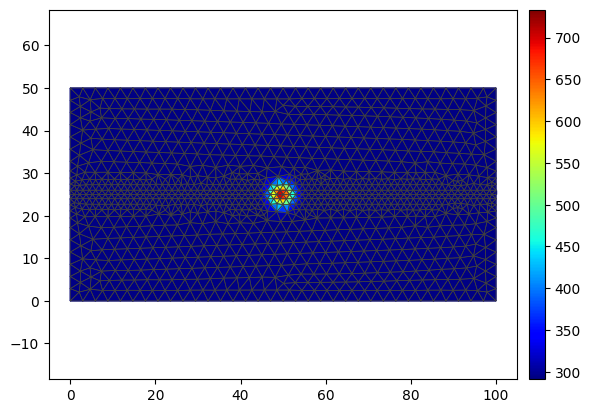

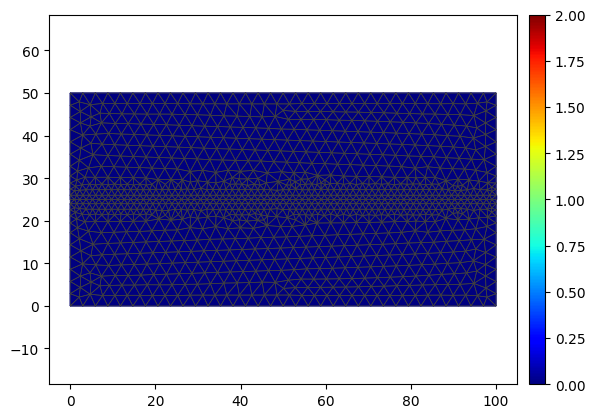

Error at 1 iteration at time 0.4 is 9.28E+01
Error at 2 iteration at time 0.4 is 1.65E+00
Error at 3 iteration at time 0.4 is 3.12E-02
Error at 4 iteration at time 0.4 is 6.04E-04
Phase change correction
Error at 1 iteration at time 0.4 is 1.18E-05


Error at 1 iteration at time 0.44 is 8.99E+01
Error at 2 iteration at time 0.44 is 1.59E+00
Error at 3 iteration at time 0.44 is 3.03E-02
Error at 4 iteration at time 0.44 is 5.90E-04
Phase change correction
Error at 1 iteration at time 0.44 is 1.16E-05


Error at 1 iteration at time 0.48 is 8.73E+01
Error at 2 iteration at time 0.48 is 1.55E+00
Error at 3 iteration at time 0.48 is 2.95E-02
Error at 4 iteration at time 0.48 is 5.81E-04
Phase change correction
Error at 1 iteration at time 0.48 is 1.15E-05


Error at 1 iteration at time 0.52 is 8.50E+01
Error at 2 iteration at time 0.52 is 1.51E+00
Error at 3 iteration at time 0.52 is 2.90E-02
Error at 4 iteration at time 0.52 is 5.75E-04
Phase change correction
Error at 1 iteration at time 

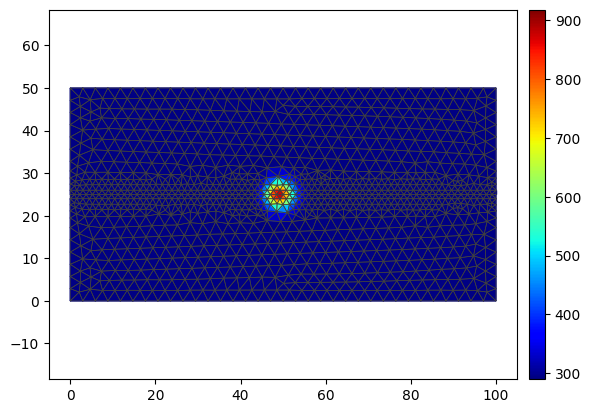

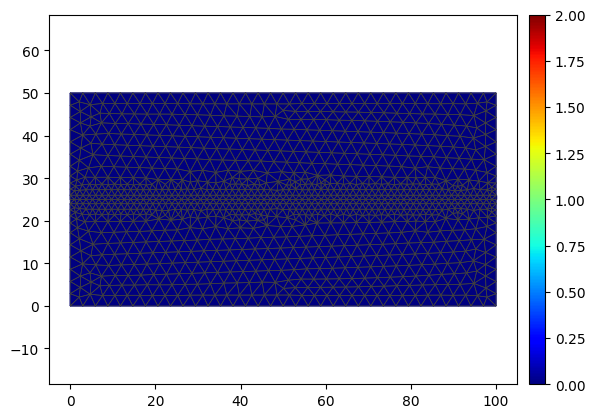

Error at 1 iteration at time 0.8 is 7.42E+01
Error at 2 iteration at time 0.8 is 1.35E+00
Error at 3 iteration at time 0.8 is 2.77E-02
Error at 4 iteration at time 0.8 is 5.95E-04
Phase change correction
Error at 1 iteration at time 0.8 is 1.31E-05


Error at 1 iteration at time 0.84 is 7.32E+01
Error at 2 iteration at time 0.84 is 1.34E+00
Error at 3 iteration at time 0.84 is 2.77E-02
Error at 4 iteration at time 0.84 is 6.03E-04
Phase change correction
Error at 1 iteration at time 0.84 is 1.34E-05


Error at 1 iteration at time 0.88 is 7.23E+01
Error at 2 iteration at time 0.88 is 1.33E+00
Error at 3 iteration at time 0.88 is 2.78E-02
Error at 4 iteration at time 0.88 is 6.12E-04
Phase change correction
Error at 1 iteration at time 0.88 is 1.38E-05


Error at 1 iteration at time 0.92 is 7.15E+01
Error at 2 iteration at time 0.92 is 1.32E+00
Error at 3 iteration at time 0.92 is 2.78E-02
Error at 4 iteration at time 0.92 is 6.20E-04
Phase change correction
Error at 1 iteration at time 

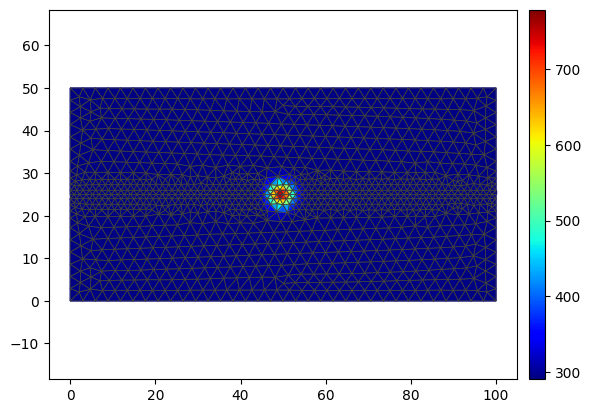

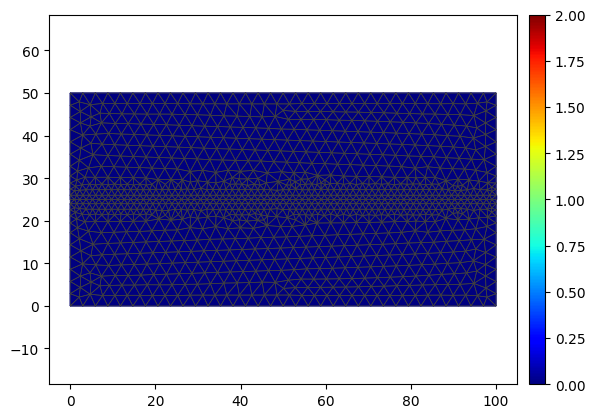

Error at 1 iteration at time 0.5 is 1.07E+02
Error at 2 iteration at time 0.5 is 2.08E+00
Error at 3 iteration at time 0.5 is 4.28E-02
Error at 4 iteration at time 0.5 is 8.98E-04
Phase change correction
Error at 1 iteration at time 0.5 is 1.91E-05


Error at 1 iteration at time 0.55 is 1.04E+02
Error at 2 iteration at time 0.55 is 2.01E+00
Error at 3 iteration at time 0.55 is 4.15E-02
Error at 4 iteration at time 0.55 is 8.78E-04
Phase change correction
Error at 1 iteration at time 0.55 is 1.87E-05


Error at 1 iteration at time 0.6000000000000001 is 1.01E+02
Error at 2 iteration at time 0.6000000000000001 is 1.96E+00
Error at 3 iteration at time 0.6000000000000001 is 4.06E-02
Error at 4 iteration at time 0.6000000000000001 is 8.65E-04
Phase change correction
Error at 1 iteration at time 0.6000000000000001 is 1.86E-05


Error at 1 iteration at time 0.65 is 9.85E+01
Error at 2 iteration at time 0.65 is 1.91E+00
Error at 3 iteration at time 0.65 is 3.99E-02
Error at 4 iteration at time 

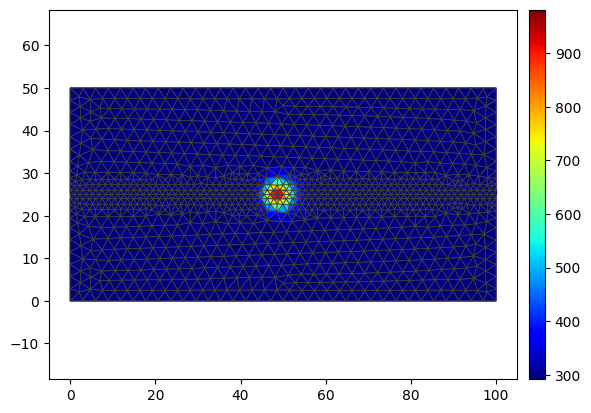

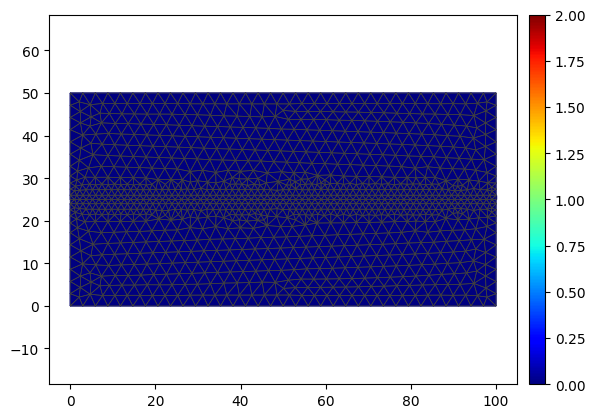

Error at 1 iteration at time 1.0 is 8.75E+01
Error at 2 iteration at time 1.0 is 1.74E+00
Error at 3 iteration at time 1.0 is 3.88E-02
Error at 4 iteration at time 1.0 is 9.12E-04
Phase change correction
Error at 1 iteration at time 1.0 is 2.20E-05


Number of times phase oscillated : 0
Maximum temperature is 993.3308124244729 K
Error at 1 iteration at time 0.0 is 2.58E+02
Error at 2 iteration at time 0.0 is 1.12E+01
Error at 3 iteration at time 0.0 is 3.72E-01
Error at 4 iteration at time 0.0 is 1.27E-02
Error at 5 iteration at time 0.0 is 4.35E-04
Phase change correction
Error at 1 iteration at time 0.0 is 1.49E-05


Error at 1 iteration at time 0.06666666666666667 is 2.27E+02
Error at 2 iteration at time 0.06666666666666667 is 7.85E+00
Error at 3 iteration at time 0.06666666666666667 is 2.32E-01
Error at 4 iteration at time 0.06666666666666667 is 6.93E-03
Phase change correction
Error at 1 iteration at time 0.06666666666666667 is 2.07E-04


Error at 1 iteration at time 0.13333333333

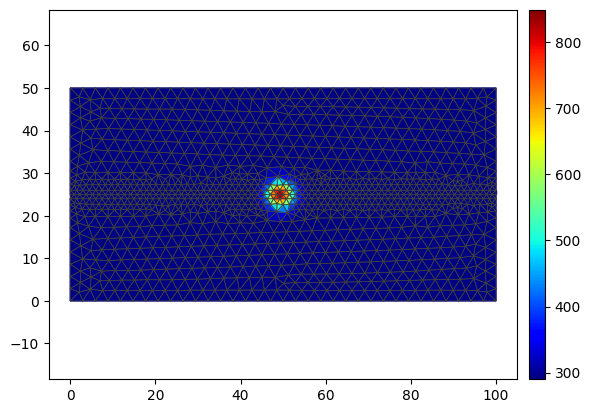

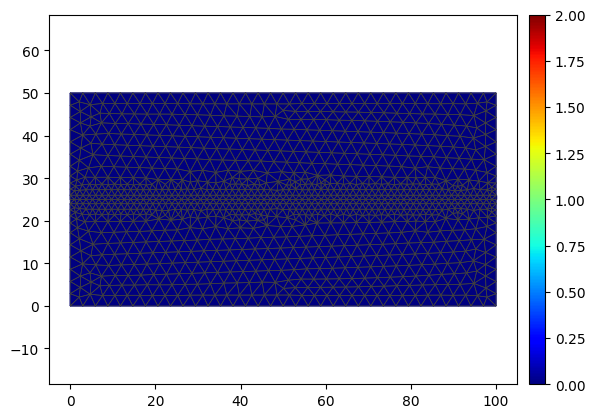

Error at 1 iteration at time 0.6666666666666666 is 1.30E+02
Error at 2 iteration at time 0.6666666666666666 is 2.84E+00
Error at 3 iteration at time 0.6666666666666666 is 6.48E-02
Error at 4 iteration at time 0.6666666666666666 is 1.51E-03
Phase change correction
Error at 1 iteration at time 0.6666666666666666 is 3.56E-05


Error at 1 iteration at time 0.7333333333333333 is 1.26E+02
Error at 2 iteration at time 0.7333333333333333 is 2.76E+00
Error at 3 iteration at time 0.7333333333333333 is 6.33E-02
Error at 4 iteration at time 0.7333333333333333 is 1.49E-03
Phase change correction
Error at 1 iteration at time 0.7333333333333333 is 3.55E-05


Error at 1 iteration at time 0.8 is 1.23E+02
Error at 2 iteration at time 0.8 is 2.70E+00
Error at 3 iteration at time 0.8 is 6.23E-02
Error at 4 iteration at time 0.8 is 1.49E-03
Phase change correction
Error at 1 iteration at time 0.8 is 3.59E-05


Error at 1 iteration at time 0.8666666666666667 is 1.20E+02
Error at 2 iteration at time 0.866666

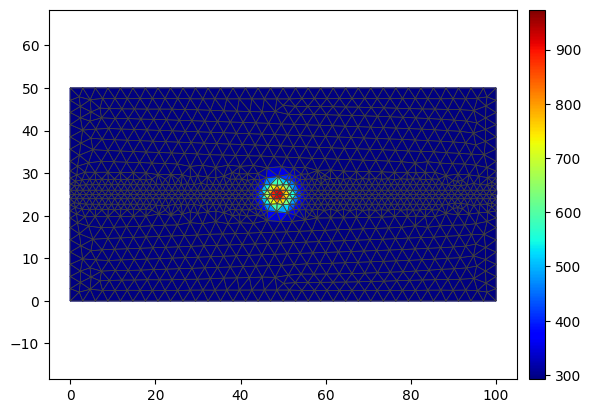

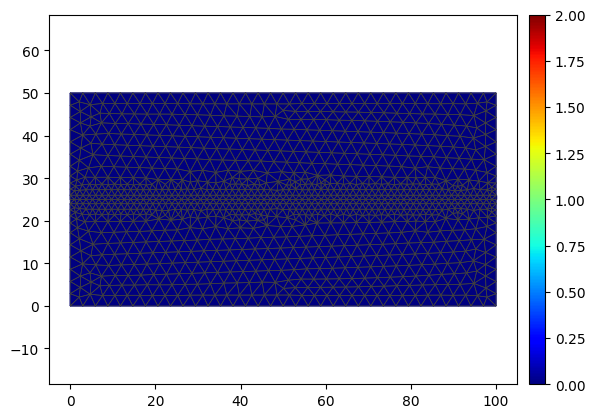

Error at 1 iteration at time 1.0 is 1.73E+02
Error at 2 iteration at time 1.0 is 4.62E+00
Error at 3 iteration at time 1.0 is 1.24E-01
Error at 4 iteration at time 1.0 is 3.41E-03
Phase change correction
Error at 1 iteration at time 1.0 is 9.54E-05


Number of times phase oscillated : 0
Maximum temperature is 998.2072518931412 K
Error at 1 iteration at time 0.0 is 6.75E+02
Error at 2 iteration at time 0.0 is 6.62E+01
Error at 3 iteration at time 0.0 is 3.48E+00
Error at 4 iteration at time 0.0 is 2.04E-01
Error at 5 iteration at time 0.0 is 1.19E-02
Error at 6 iteration at time 0.0 is 6.95E-04
Phase change correction
Error at 1 iteration at time 0.0 is 4.06E-05


Error at 1 iteration at time 0.2 is 5.17E+02
Error at 2 iteration at time 0.2 is 3.11E+01
Error at 3 iteration at time 0.2 is 1.35E+00
Error at 4 iteration at time 0.2 is 6.02E-02
Error at 5 iteration at time 0.2 is 2.69E-03
Phase change correction
Error at 1 iteration at time 0.2 is 1.20E-04


Error at 1 iteration at time 0.4

In [12]:
#at around 0.05 seconds, the temperature stabilises at 976 K
iters = np.arange(30,0,-5)
# iters = [2]
converged_msf = 3
converged_msf_adapt = 1.5
T_l = 20+273
rep = np.array([[48,25,0]]).reshape(1,-1)
mesh_sizes = []
n_eles = []
T_reps = []
t_final = 1
nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                msf_all=converged_msf,
                                msf_adapt = converged_msf_adapt,
                                length = 100,
                                width = 8,
                                x_s = 50,
                                y_s = 25) 
for iter in iters:
    dt = t_final/iter
    theta_init = np.zeros((nodecoords.shape[0],1))+T_l
    _,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[50,25]],dtype = np.float32),theta_init,dt = dt,t_final =t_final+1e-3,type = "transient",mode = "phase_change")
    econ,eeta,zeta = find_triangle_params(rep,nodecoords,ele_con)
    N = np.array([[1-eeta-zeta,eeta,zeta]])
    T_reps.append((N@theta_fin[np.ix_(econ,[0])])[0][0])
    print(f"Maximum temperature is {np.max(theta_fin)} K")

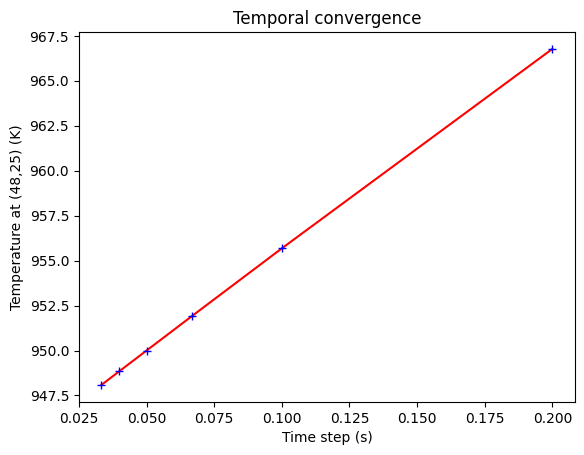

In [21]:
plt.plot(t_final/iters,T_reps,color='red', linestyle='-', marker='+', markeredgecolor='blue')
plt.title('Temporal convergence')
plt.xlabel('Time step (s)')
plt.ylabel(r'Temperature at (48,25) (K)')
plt.show()

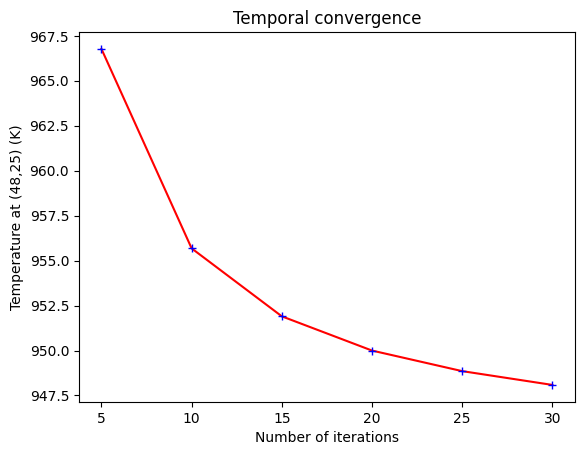

In [20]:
plt.plot(iters,T_reps,color='red', linestyle='-', marker='+', markeredgecolor='blue')
plt.title('Temporal convergence')
plt.xlabel('Number of iterations')
plt.ylabel(r'Temperature at (48,25) (K)')
plt.show()

In [13]:
T_reps

[np.float64(948.0871934207062),
 np.float64(948.8542138448887),
 np.float64(949.9977566819468),
 np.float64(951.9015473519821),
 np.float64(955.6792801323523),
 np.float64(966.7698970715887)]

Reading reqd_mesh.msh
Number of nodes in the mesh: 1100
Number of triangles in the mesh: 2086

Error at 1 iteration at time 0.0 is 1.86E+02
Error at 2 iteration at time 0.0 is 6.79E+00
Error at 3 iteration at time 0.0 is 1.92E-01
Error at 4 iteration at time 0.0 is 5.54E-03
Phase change correction
Error at 1 iteration at time 0.0 is 1.60E-04


Error at 1 iteration at time 0.05 is 1.72E+02
Error at 2 iteration at time 0.05 is 5.31E+00
Error at 3 iteration at time 0.05 is 1.42E-01
Error at 4 iteration at time 0.05 is 3.83E-03
Phase change correction
Error at 1 iteration at time 0.05 is 1.03E-04


Error at 1 iteration at time 0.1 is 1.62E+02
Error at 2 iteration at time 0.1 is 4.46E+00
Error at 3 iteration at time 0.1 is 1.14E-01
Error at 4 iteration at time 0.1 is 2.93E-03
Phase change correction
Error at 1 iteration at time 0.1 is 7.51E-05


Error at 1 iteration at time 0.15000000000000002 is 1.54E+02
Error at 2 iteration at time 0.15000000000000002 is 3.93E+00
Error at 3 iteration at t

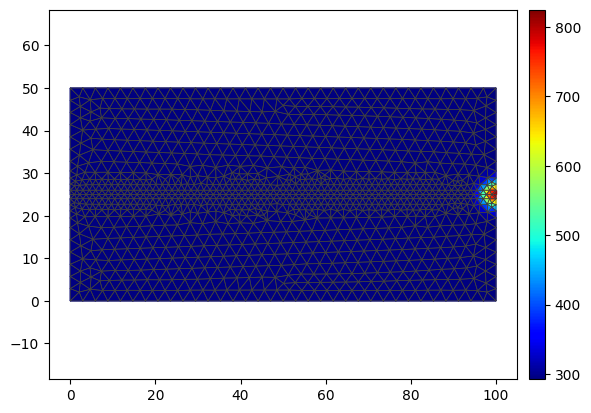

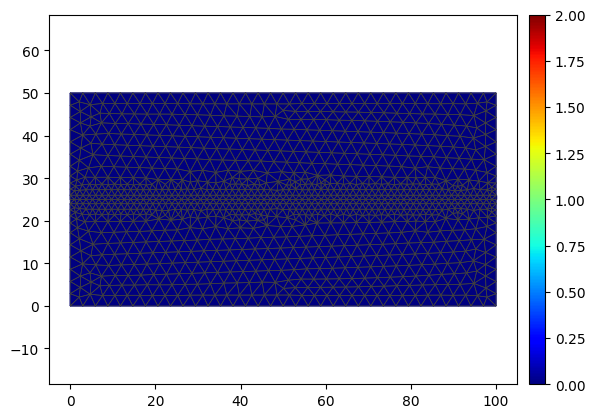

Error at 1 iteration at time 0.5 is 1.26E+02
Error at 2 iteration at time 0.5 is 2.82E+00
Error at 3 iteration at time 0.5 is 6.87E-02
Error at 4 iteration at time 0.5 is 1.72E-03
Phase change correction
Error at 1 iteration at time 0.5 is 4.36E-05


Error at 1 iteration at time 0.55 is 1.23E+02
Error at 2 iteration at time 0.55 is 2.77E+00
Error at 3 iteration at time 0.55 is 6.81E-02
Error at 4 iteration at time 0.55 is 1.73E-03
Phase change correction
Error at 1 iteration at time 0.55 is 4.47E-05


Error at 1 iteration at time 0.6000000000000001 is 1.20E+02
Error at 2 iteration at time 0.6000000000000001 is 2.72E+00
Error at 3 iteration at time 0.6000000000000001 is 6.79E-02
Error at 4 iteration at time 0.6000000000000001 is 1.76E-03
Phase change correction
Error at 1 iteration at time 0.6000000000000001 is 4.65E-05


Error at 1 iteration at time 0.65 is 1.18E+02
Error at 2 iteration at time 0.65 is 2.68E+00
Error at 3 iteration at time 0.65 is 6.80E-02
Error at 4 iteration at time 

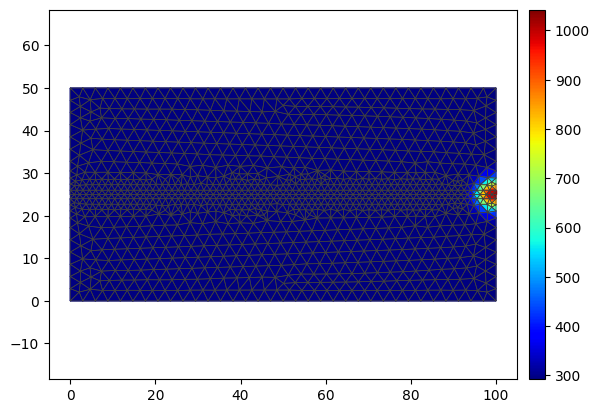

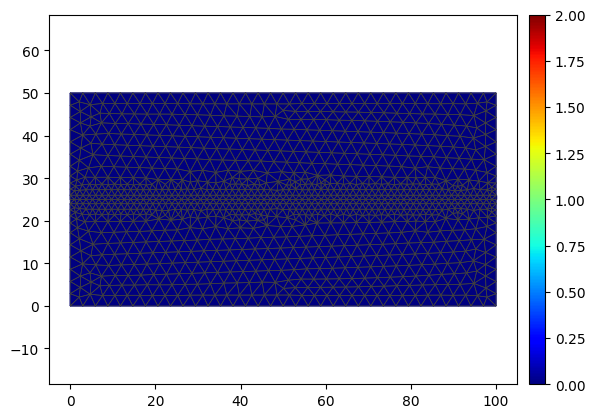

Error at 1 iteration at time 1.0 is 1.02E+02
Error at 2 iteration at time 1.0 is 2.41E+00
Error at 3 iteration at time 1.0 is 6.82E-02
Error at 4 iteration at time 1.0 is 2.10E-03
Phase change correction
Error at 1 iteration at time 1.0 is 6.75E-05


Error at 1 iteration at time 1.05 is 9.96E+01
Error at 2 iteration at time 1.05 is 2.37E+00
Error at 3 iteration at time 1.05 is 6.72E-02
Error at 4 iteration at time 1.05 is 2.09E-03
Phase change correction
Error at 1 iteration at time 1.05 is 6.77E-05


Error at 1 iteration at time 1.1 is 9.77E+01
Error at 2 iteration at time 1.1 is 2.32E+00
Error at 3 iteration at time 1.1 is 6.58E-02
Error at 4 iteration at time 1.1 is 2.05E-03
Phase change correction
Error at 1 iteration at time 1.1 is 6.69E-05


Error at 1 iteration at time 1.1500000000000001 is 9.60E+01
Error at 2 iteration at time 1.1500000000000001 is 2.27E+00
Error at 3 iteration at time 1.1500000000000001 is 6.41E-02
Error at 4 iteration at time 1.1500000000000001 is 2.00E-03
Ph

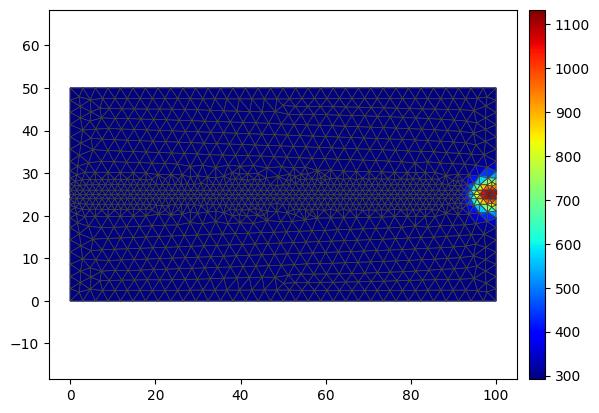

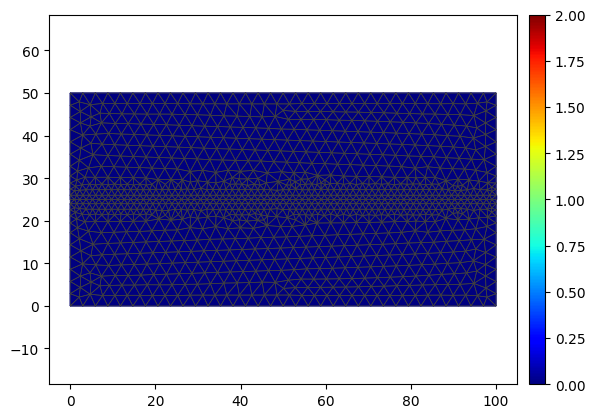

Error at 1 iteration at time 1.5 is 8.70E+01
Error at 2 iteration at time 1.5 is 2.05E+00
Error at 3 iteration at time 1.5 is 5.82E-02
Error at 4 iteration at time 1.5 is 1.81E-03
Phase change correction
Error at 1 iteration at time 1.5 is 5.83E-05


Error at 1 iteration at time 1.55 is 8.61E+01
Error at 2 iteration at time 1.55 is 2.03E+00
Error at 3 iteration at time 1.55 is 5.78E-02
Error at 4 iteration at time 1.55 is 1.80E-03
Phase change correction
Error at 1 iteration at time 1.55 is 5.86E-05


Error at 1 iteration at time 1.6 is 8.52E+01
Error at 2 iteration at time 1.6 is 2.00E+00
Error at 3 iteration at time 1.6 is 5.69E-02
Error at 4 iteration at time 1.6 is 1.78E-03
Phase change correction
Error at 1 iteration at time 1.6 is 5.79E-05


Error at 1 iteration at time 1.6500000000000001 is 8.45E+01
Error at 2 iteration at time 1.6500000000000001 is 1.97E+00
Error at 3 iteration at time 1.6500000000000001 is 5.57E-02
Error at 4 iteration at time 1.6500000000000001 is 1.73E-03
Ph

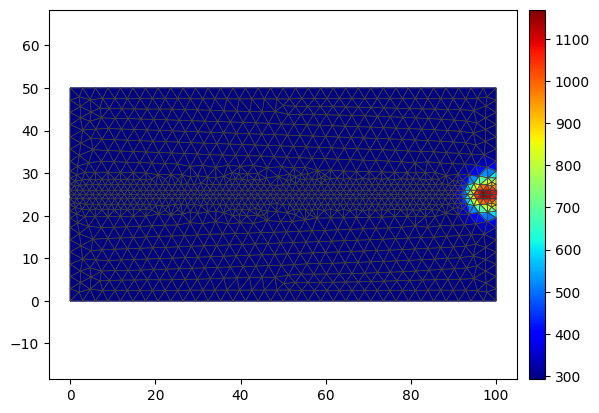

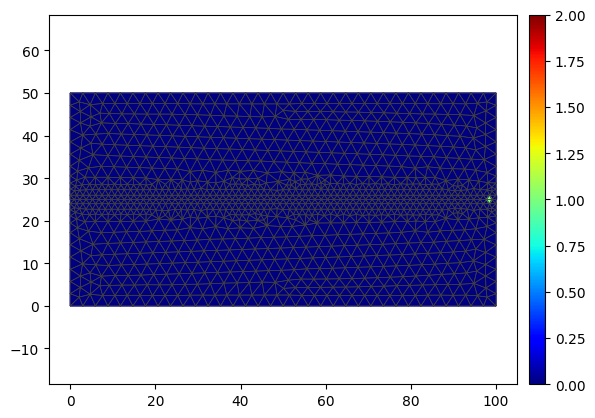

Error at 1 iteration at time 2.0 is 8.14E+01
Error at 2 iteration at time 2.0 is 1.91E+00
Error at 3 iteration at time 2.0 is 5.40E-02
Error at 4 iteration at time 2.0 is 1.65E-03
Phase change correction
Error at 1 iteration at time 2.0 is 5.24E-05


Error at 1 iteration at time 2.0500000000000003 is 8.12E+01
Error at 2 iteration at time 2.0500000000000003 is 1.91E+00
Error at 3 iteration at time 2.0500000000000003 is 5.48E-02
Error at 4 iteration at time 2.0500000000000003 is 1.70E-03
Phase change correction
Error at 1 iteration at time 2.0500000000000003 is 5.46E-05


Error at 1 iteration at time 2.1 is 8.10E+01
Error at 2 iteration at time 2.1 is 1.92E+00
Error at 3 iteration at time 2.1 is 5.55E-02
Error at 4 iteration at time 2.1 is 1.74E-03
Phase change correction
Error at 1 iteration at time 2.1 is 5.67E-05


Error at 1 iteration at time 2.15 is 8.08E+01
Error at 2 iteration at time 2.15 is 1.91E+00
Error at 3 iteration at time 2.15 is 5.56E-02
Error at 4 iteration at time 2.15 

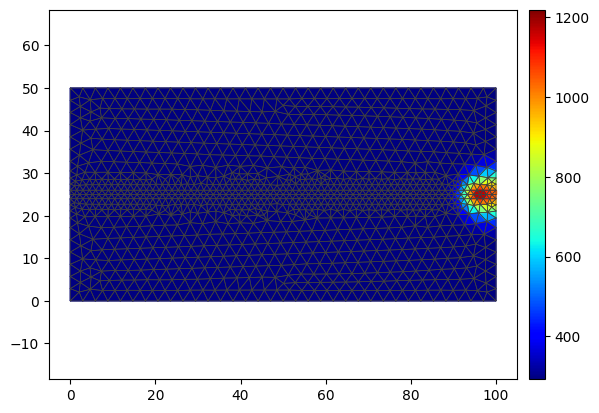

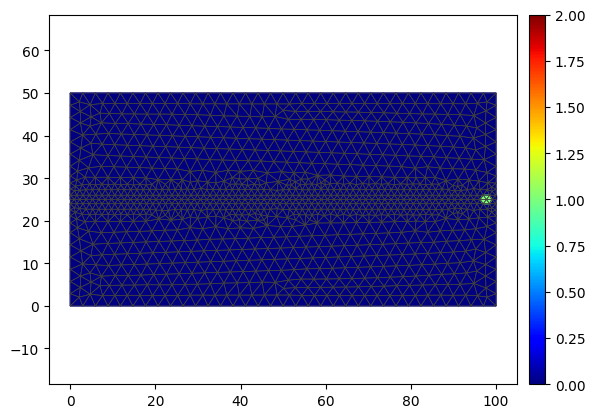

Error at 1 iteration at time 2.5 is 8.07E+01
Error at 2 iteration at time 2.5 is 1.86E+00
Error at 3 iteration at time 2.5 is 5.14E-02
Error at 4 iteration at time 2.5 is 1.53E-03
Phase change correction
Error at 1 iteration at time 2.5 is 4.72E-05


Error at 1 iteration at time 2.5500000000000003 is 8.07E+01
Error at 2 iteration at time 2.5500000000000003 is 1.87E+00
Error at 3 iteration at time 2.5500000000000003 is 5.22E-02
Error at 4 iteration at time 2.5500000000000003 is 1.56E-03
Phase change correction
Error at 1 iteration at time 2.5500000000000003 is 1.84E+00
Error at 2 iteration at time 2.5500000000000003 is 2.58E-02
Error at 3 iteration at time 2.5500000000000003 is 5.12E-04
Number of phases which don't match :  2.0
Phase not reconciled


Error at 1 iteration at time 2.6 is 8.08E+01
Error at 2 iteration at time 2.6 is 1.89E+00
Error at 3 iteration at time 2.6 is 5.33E-02
Error at 4 iteration at time 2.6 is 1.62E-03
Phase change correction
Error at 1 iteration at time 2.6 is 

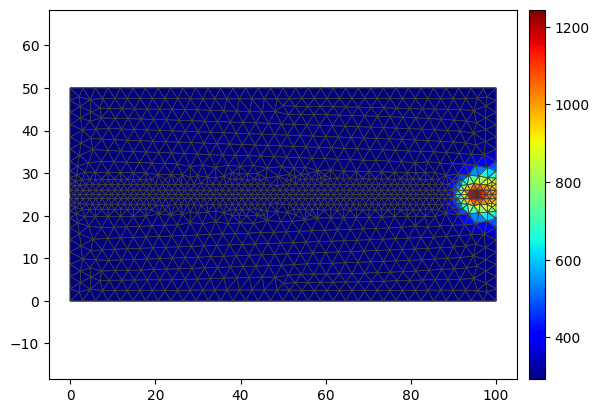

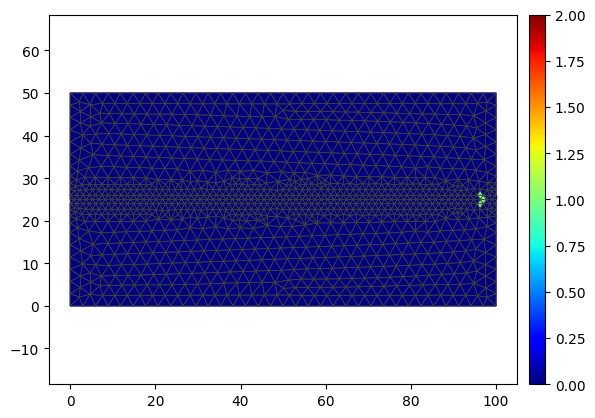

Error at 1 iteration at time 3.0 is 8.17E+01
Error at 2 iteration at time 3.0 is 1.91E+00
Error at 3 iteration at time 3.0 is 5.36E-02
Error at 4 iteration at time 3.0 is 1.63E-03
Phase change correction
Error at 1 iteration at time 3.0 is 5.21E-05


Error at 1 iteration at time 3.0500000000000003 is 8.18E+01
Error at 2 iteration at time 3.0500000000000003 is 1.90E+00
Error at 3 iteration at time 3.0500000000000003 is 5.26E-02
Error at 4 iteration at time 3.0500000000000003 is 1.58E-03
Phase change correction
Error at 1 iteration at time 3.0500000000000003 is 4.93E-05


Error at 1 iteration at time 3.1 is 8.20E+01
Error at 2 iteration at time 3.1 is 1.90E+00
Error at 3 iteration at time 3.1 is 5.22E-02
Error at 4 iteration at time 3.1 is 1.54E-03
Phase change correction
Error at 1 iteration at time 3.1 is 4.77E-05


Error at 1 iteration at time 3.1500000000000004 is 8.21E+01
Error at 2 iteration at time 3.1500000000000004 is 1.91E+00
Error at 3 iteration at time 3.1500000000000004 is 5

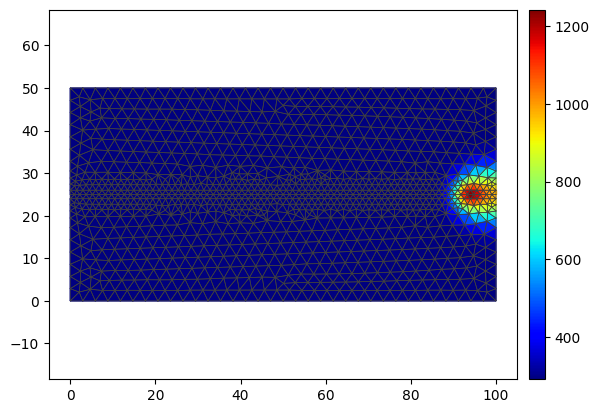

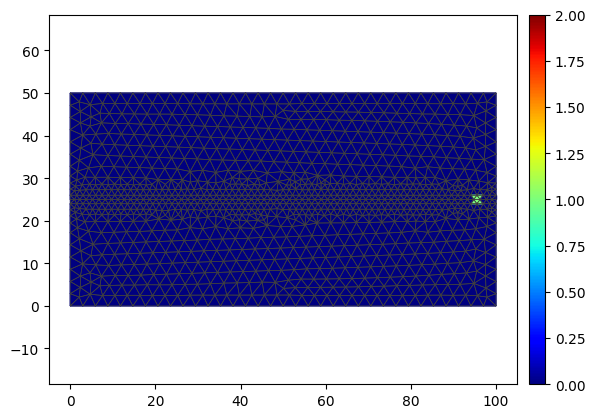

Error at 1 iteration at time 3.5 is 8.23E+01
Error at 2 iteration at time 3.5 is 2.01E+00
Error at 3 iteration at time 3.5 is 5.92E-02
Error at 4 iteration at time 3.5 is 1.89E-03
Phase change correction
Error at 1 iteration at time 3.5 is 6.26E-05


Error at 1 iteration at time 3.5500000000000003 is 8.23E+01
Error at 2 iteration at time 3.5500000000000003 is 2.01E+00
Error at 3 iteration at time 3.5500000000000003 is 5.88E-02
Error at 4 iteration at time 3.5500000000000003 is 1.87E-03
Phase change correction
Error at 1 iteration at time 3.5500000000000003 is 6.19E-05


Error at 1 iteration at time 3.6 is 8.23E+01
Error at 2 iteration at time 3.6 is 2.00E+00
Error at 3 iteration at time 3.6 is 5.80E-02
Error at 4 iteration at time 3.6 is 1.83E-03
Phase change correction
Error at 1 iteration at time 3.6 is 6.00E-05


Error at 1 iteration at time 3.6500000000000004 is 8.22E+01
Error at 2 iteration at time 3.6500000000000004 is 1.98E+00
Error at 3 iteration at time 3.6500000000000004 is 5

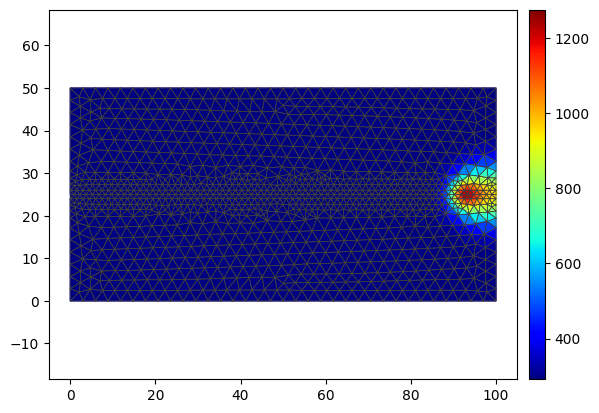

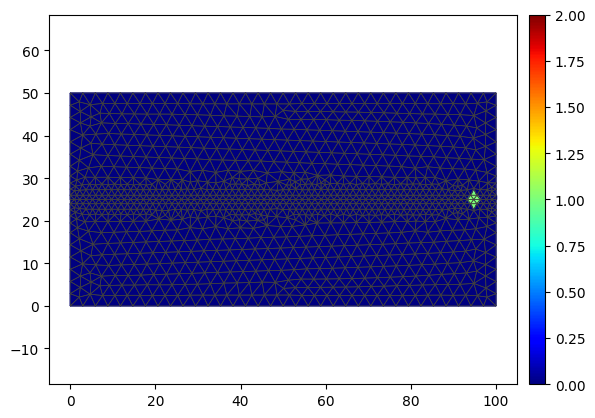

Error at 1 iteration at time 4.0 is 8.16E+01
Error at 2 iteration at time 4.0 is 2.01E+00
Error at 3 iteration at time 4.0 is 5.84E-02
Error at 4 iteration at time 4.0 is 1.80E-03
Phase change correction
Error at 1 iteration at time 4.0 is 5.75E-05


Error at 1 iteration at time 4.05 is 8.14E+01
Error at 2 iteration at time 4.05 is 2.03E+00
Error at 3 iteration at time 4.05 is 5.97E-02
Error at 4 iteration at time 4.05 is 1.87E-03
Phase change correction
Error at 1 iteration at time 4.05 is 6.08E-05


Error at 1 iteration at time 4.1000000000000005 is 8.12E+01
Error at 2 iteration at time 4.1000000000000005 is 2.04E+00
Error at 3 iteration at time 4.1000000000000005 is 6.05E-02
Error at 4 iteration at time 4.1000000000000005 is 1.92E-03
Phase change correction
Error at 1 iteration at time 4.1000000000000005 is 2.79E+00
Error at 2 iteration at time 4.1000000000000005 is 4.69E-02
Error at 3 iteration at time 4.1000000000000005 is 1.08E-03
Number of phases which don't match :  2.0
Phase n

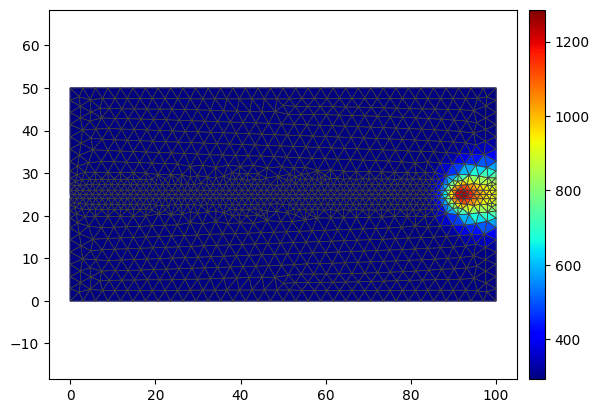

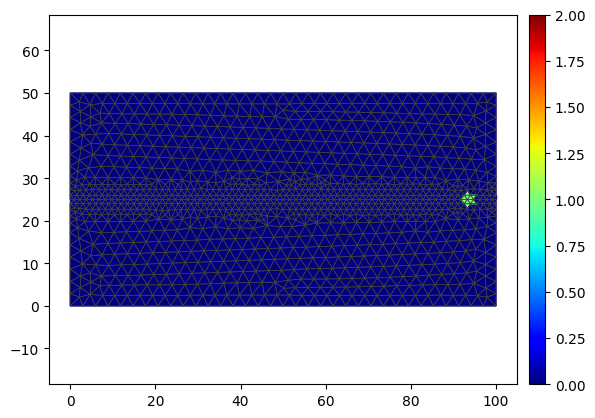

Error at 1 iteration at time 4.5 is 7.95E+01
Error at 2 iteration at time 4.5 is 1.95E+00
Error at 3 iteration at time 4.5 is 5.55E-02
Error at 4 iteration at time 4.5 is 1.67E-03
Phase change correction
Error at 1 iteration at time 4.5 is 5.24E-05


Error at 1 iteration at time 4.55 is 7.93E+01
Error at 2 iteration at time 4.55 is 1.95E+00
Error at 3 iteration at time 4.55 is 5.55E-02
Error at 4 iteration at time 4.55 is 1.67E-03
Phase change correction
Error at 1 iteration at time 4.55 is 5.21E-05


Error at 1 iteration at time 4.6000000000000005 is 7.89E+01
Error at 2 iteration at time 4.6000000000000005 is 1.95E+00
Error at 3 iteration at time 4.6000000000000005 is 5.62E-02
Error at 4 iteration at time 4.6000000000000005 is 1.71E-03
Phase change correction
Error at 1 iteration at time 4.6000000000000005 is 5.38E-05


Error at 1 iteration at time 4.65 is 7.87E+01
Error at 2 iteration at time 4.65 is 1.97E+00
Error at 3 iteration at time 4.65 is 5.74E-02
Error at 4 iteration at time 

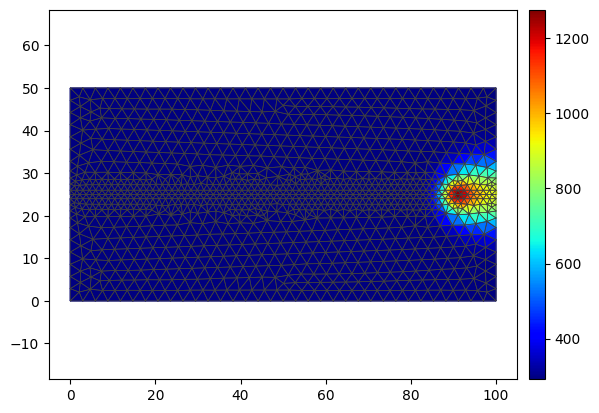

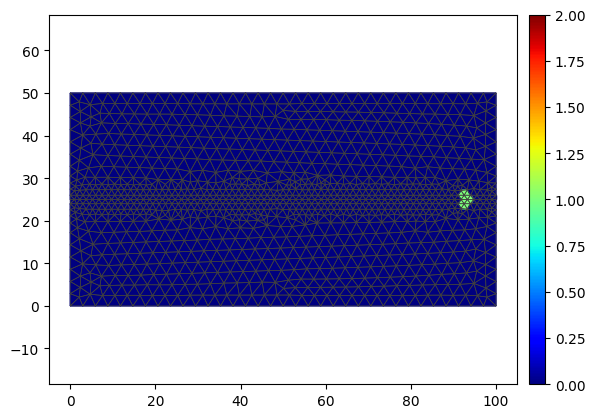

Error at 1 iteration at time 5.0 is 7.77E+01
Error at 2 iteration at time 5.0 is 1.98E+00
Error at 3 iteration at time 5.0 is 5.98E-02
Error at 4 iteration at time 5.0 is 1.94E-03
Phase change correction
Error at 1 iteration at time 5.0 is 6.52E-05


Number of times phase oscillated : 10


In [4]:
converged_msf = 3
converged_msf_adapt = 1.5
converged_dt = 0.05
T_l = 20+273
t_final = 5
nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                msf_all=converged_msf,
                                msf_adapt = converged_msf_adapt,
                                length = 100,
                                width = 8,
                                x_s = 50,
                                y_s = 25) 
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
_,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[100,25]],dtype = np.float32),theta_init,dt = converged_dt,\
                                t_final =t_final+1e-3,type = "transient",mode = "phase_change")

In [7]:
phase_cur

NameError: name 'phase_cur' is not defined

## Adaptive meshing

### Mesh convergence

In [ ]:
# Finding mesh size factor for the adaptive mesh part
mesh_size_factor = 3
area_patch = 12 * 12
area_all = 100*50
msf_patch_all = np.arange(0.1,0.2,0.01)
h_patch = []
h = []
for msf_patch in msf_patch_all:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                        msf_all=mesh_size_factor,
                                        msf_adapt=msf_patch,
                                        side = 12,
                                        x_s=50,
                                        y_s=25,
                                        is_adapt=True
                                    )
    nodes_patch = np.where((np.max(nodecoords[ele_con-1][:,:,0],axis=1)<56)*(np.min(nodecoords[ele_con-1][:,:,0],axis=1)>44)*(np.max(nodecoords[ele_con-1][:,:,1],axis=1)<31)*(np.min(nodecoords[ele_con-1][:,:,1],axis=1)>19))[0]
    h_patch.append((area_patch / len(nodes_patch))**.5)
    h.append((area_all/ len(nodecoords))**.5)

In [ ]:
plt.plot(msf_patch_all,h_patch,'r')
plt.xlabel('Mesh Size Factor')
plt.ylabel('Value of h_patch (mm)')
plt.title('Plot of $h$ v/s Mesh Size Factor (for source term only)')
plt.show()

In [ ]:
print(f'Value of h for mesh size factor 0.15 is '+str(h_patch[5]))

In [ ]:
gc.collect()

In [ ]:
# mesh convergence for the coarser part given that for finer the factor is 0.15
mesh_size_factors = np.array([1]+ np.arange(5,50,5).tolist())
converged_msf_patch = 0.15

#representative point
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
n_ele = []
for mesh_size_factor in mesh_size_factors:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                        msf_all=mesh_size_factor,
                                        msf_adapt=converged_msf_patch,
                                        side = 12,
                                        x_s=50,
                                        y_s=25,
                                        is_adapt=True
                                    )
    soln_qs_p = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln_qs_p.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    n_ele.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size factors')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
ele = np.argsort(n_ele)
plt.plot(np.array(n_ele)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
x = np.log(mesh_size_factors[2:])
y = np.log(T_reps[2:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

In [ ]:
gc.collect()

## Final solution

In [ ]:
# Final solution for Titanium alloy with assumed properties and no physical modelling
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = [12.5,25,37.5]
converged_msf = 1
x_source = 100
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all=converged_msf,
                                msf_adapt=converged_msf_patch,
                                side = 12,
                                x_s=x_source-times[0]*vo,
                                y_s=25,
                                is_adapt=True)

theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
for i,t in enumerate(times):
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=converged_msf,
                                    msf_adapt=converged_msf_patch,
                                    side = 12,
                                    x_s=x_source-vo*t,
                                    y_s=25,
                                    is_adapt=True
                                )
    print(f"Time is {t} seconds")
    theta_final = quasi_static_picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source-vo*t,25]]))
    nodecoords,_ = createMesh(geo_file='rectangle.geo',
                                    msf_all=converged_msf,
                                    msf_adapt=converged_msf_patch,
                                    side = 12,
                                    x_s=x_source-vo*(times[i+1] if i+1 < len(times) else 0),
                                    y_s=25,
                                    is_adapt=True
                                )
    theta_prev = np.zeros((nodecoords.shape[0],1))+T_l

In [ ]:
# Normal mesh convergence for phase change consideration of Titanium alloy

mesh_size_factors = np.array(np.arange(1.5,2,0.1).tolist() + np.arange(3,10,1).tolist())
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
n_ele = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=mesh_size_factor,
                                )
    soln1 = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    n_ele.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size factors')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

In [ ]:
ele = np.argsort(n_ele)
plt.plot(np.array(n_ele)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
x = np.log(mesh_size_factors[7:])
y = np.log(T_reps[7:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

In [ ]:
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all=1
                                )
T_l = 273+500
vo = 2 #mm/s
t_final = 25
times = np.arange(0,t_final,2)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 75
for t in times:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=1
                                )
    print(f"Time is {t} seconds")
    theta_final = quasi_static_picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source-vo*t,25]]),mode="phase_change")
    theta_prev = theta_final